### UAS PMPM MobileNet
- Aldo
- 220711837
- Keras
- Cabai (Rawit, Keriting, Hijau)
- MobileNet


In [202]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten



In [203]:
count = 0 
dirs = os.listdir(r'C:\Users\Aldo\Downloads\equalized\train_data')
for dir in dirs:
    files = list(os.listdir(r'C:\Users\Aldo\Downloads\equalized\train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

Hijau Folder has 100 Images
Keriting Folder has 100 Images
Rawit Folder has 100 Images
Images Folder has 300 Images


In [204]:
base_dir = r'C:\Users\Aldo\Downloads\equalized\train_data' 
img_size = 224 
batch = 32 
validation_split = 0.1 

In [205]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, 
    seed=123, 
    image_size=(img_size, img_size), 
    batch_size=batch, 
)

Found 300 files belonging to 3 classes.


In [206]:
class_names = dataset.class_names 
print("Class Names:", class_names)

Class Names: ['Hijau', 'Keriting', 'Rawit']


In [207]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 10
Train Images: 9
Validation Images: 1


In [208]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

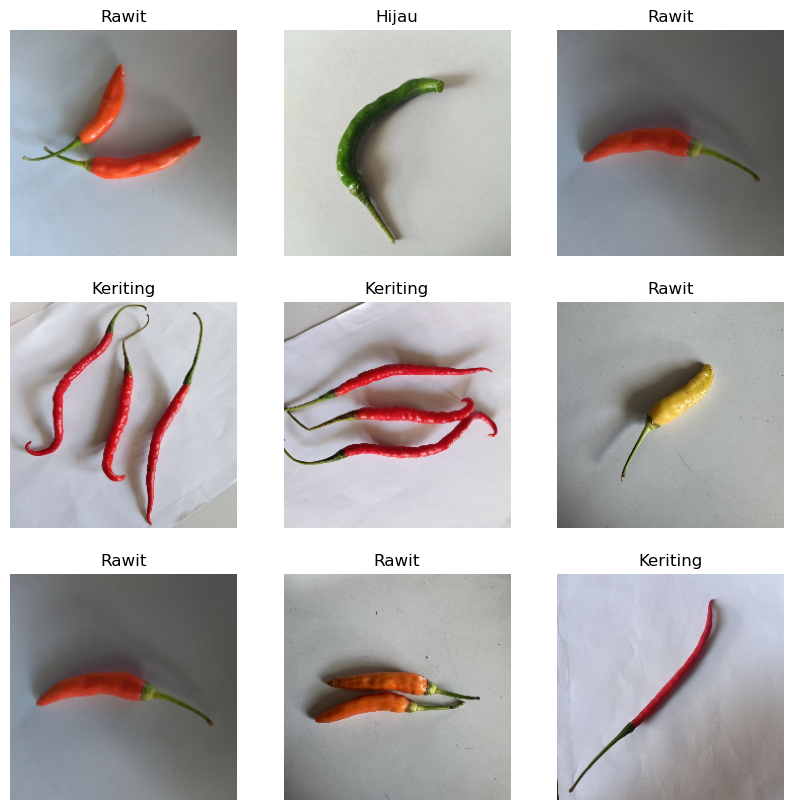

In [209]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10)) 
for images, labels in train_ds.take(1): 
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8')) 
        plt.title(class_names[labels[i]]) 
        plt.axis('off') 

In [210]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)  

(32, 224, 224, 3)


In [211]:
AUTOTUNE = tf.data.AUTOTUNE

In [212]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)


In [213]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [214]:
data_augmentation = Sequential([
    layers.RandomFlip("diagonal", input_shape = (img_size,img_size,3)), 
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.2) 
])

C:\Users\Aldo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


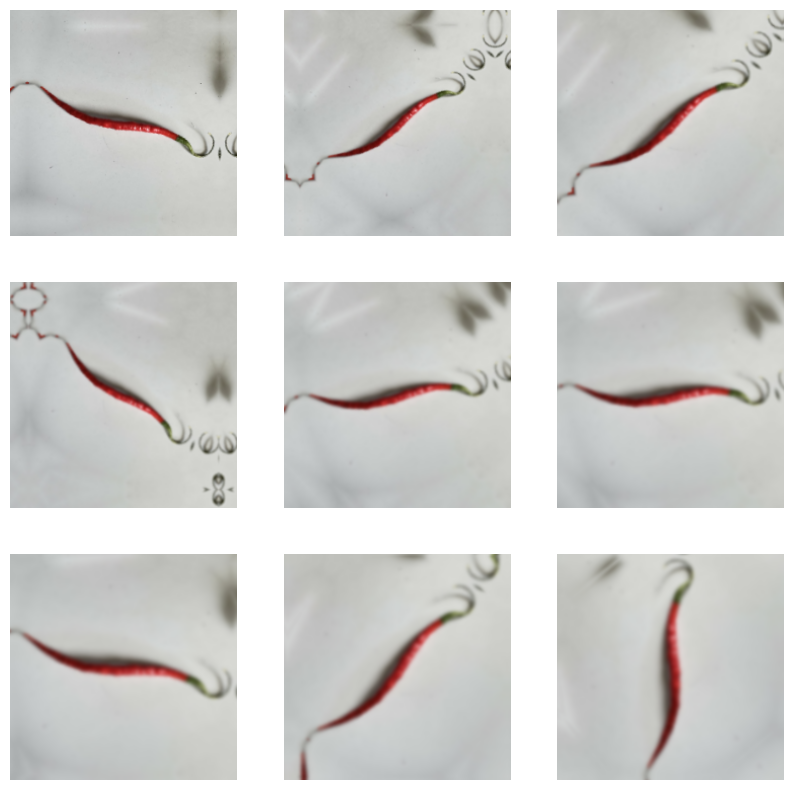

In [215]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [216]:
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.models import Model 

base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))

base_model.trainable = True 
fine_tune_at = len(base_model.layers) // 2  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False 


model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names),activation='softmax')

])

In [217]:
from tensorflow.keras.optimizers import Adam 

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'] 
)


In [218]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_18 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 3,069,443 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [219]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience =3,
                               mode = 'max')

history= model.fit(train_ds, 
                   epochs=30, 
                   validation_data=val_ds,  
                   callbacks=[early_stopping]) 

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.4944 - loss: 0.9520 - val_accuracy: 0.5833 - val_loss: 0.7501
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9104 - loss: 0.2984 - val_accuracy: 0.5833 - val_loss: 0.6683
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9677 - loss: 0.1243 - val_accuracy: 0.5833 - val_loss: 0.7335
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9846 - loss: 0.0683 - val_accuracy: 0.7500 - val_loss: 0.4797
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9913 - loss: 0.0662 - val_accuracy: 0.9167 - val_loss: 0.3336
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9974 - loss: 0.0416 - val_accuracy: 0.9167 - val_loss: 0.1874
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9812 - loss: 0.0516 - val_accuracy: 0.9167 - val_loss: 0.0979
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9888 - loss: 0.0267 - val_accuracy: 1.0000 - val_loss: 0.0550
Epoch 9/

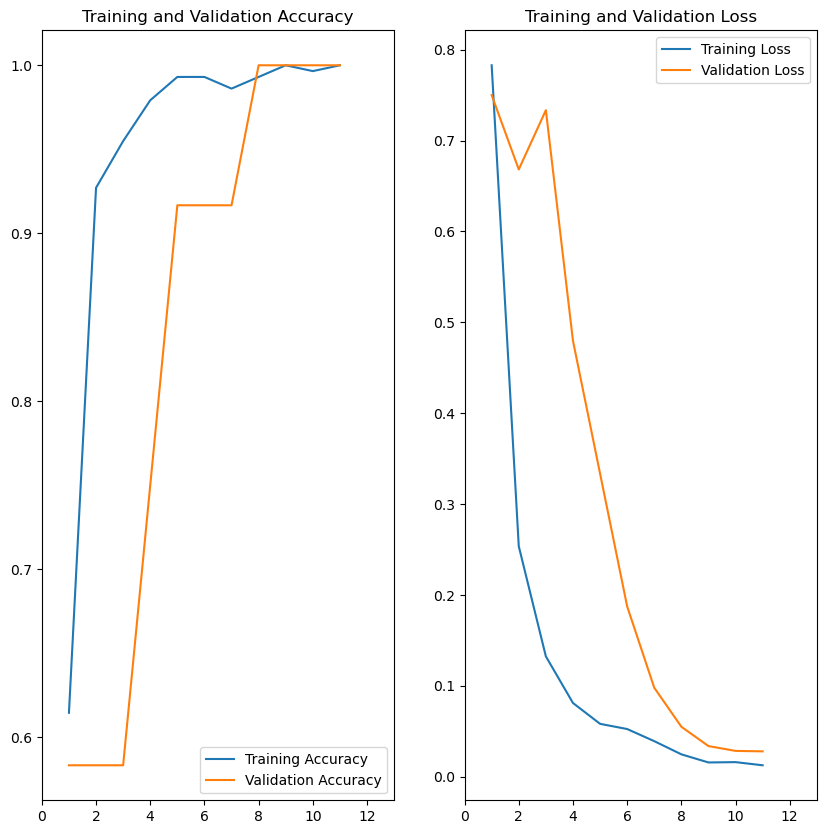

In [220]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10)) 

plt.subplot(1, 2, 1) 
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy') 
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right') 
plt.xlim(0, 13) 
plt.title('Training and Validation Accuracy') 

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [221]:
model.save('model_mobilenet.h5')

In [222]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'C:\Users\Aldo\Downloads\Tugas6_B_Aldo_11837\Tugas6_B_Aldo_11837\model_mobilenet.h5')  
class_names = ['Hijau', 'Keriting','Rawat']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(224, 224)) 
        input_image_array = tf.keras.utils.img_to_array(input_image) 
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  

        predictions = model.predict(input_image_exp_dim) 
        result = tf.nn.softmax(predictions[0]) 
        class_idx = np.argmax(result) 
        confidence = np.max(result) * 100 

        print(f"Prediksi: {class_names[class_idx]}") 
        print(f"Confidence: {confidence:.2f}%") 

        input_image = Image.open(image_path) 
        input_image.save(save_path) 

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'test_data/Keriting/Keriting (101).jpg', save_path='keriting.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi: Keriting
Confidence: 52.05%
Prediksi: Keriting dengan confidence 52.05%. Gambar asli disimpan di keriting.jpg.


Found 59 files belonging to 3 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


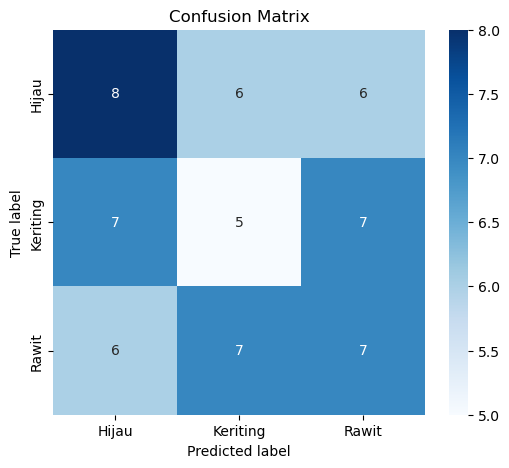

Confusion Matrix:
 [[8 6 6]
 [7 5 7]
 [6 7 7]]
Akurasi: 0.3389830508474576
Presisi: [0.38095238 0.27777778 0.35      ]
Recall: [0.4        0.26315789 0.35      ]
F1 Score: [0.3902439  0.27027027 0.35      ]


In [223]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

mobileNet_model = load_model(r'C:\Users\Aldo\Downloads\Tugas6_B_Aldo_11837\Tugas6_B_Aldo_11837\model_mobilenet.h5')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data', 
    labels='inferred', 
    label_mode='categorical',  
    batch_size=32, 
    image_size=(224, 224) 
)

y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  

true_labels = [] 
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  
true_labels = tf.convert_to_tensor(true_labels) 

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5)) 
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Hijau", "Keriting", "Rawit"], yticklabels=["Hijau", "Keriting","Rawit"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
